# **MENTAL HEALTH SEGMENTATION**

**OBJECTIVES**
1. Analyse the linguistic patterns, sentiments and mental health indicators in our dataset.
2. Assess mental health risk facors
3. Build a predictive risk model
4. Support product development
5. Segment individuals into Risk categories



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## **PREPARE DATA**

We'll download the dataset from kaggle

In [ ]:
# Create a .kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the directory
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download bhavikjikadara/mental-health-dataset

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/mental-health-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
mental-health-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q mental-health-dataset.zip

replace Mental Health Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


We'll write a wrangle function that reads in our csv data from kaggle into our dataframe

In [ ]:
def wrangle(filepath):
  # Read CSV file
  df = pd.read_csv(filepath)

  return df

In [ ]:
df = wrangle("/content/Mental Health Dataset.csv")
print(df.shape)
df.head()

(292364, 17)


,Timestamp,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options
0,8/27/2014 11:29,Female,United States,Corporate,NaN,No,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Not sure
1,8/27/2014 11:31,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,No
2,8/27/2014 11:32,Female,United States,Corporate,NaN,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes
3,8/27/2014 11:37,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,Maybe,Yes
4,8/27/2014 11:43,Female,United States,Corporate,No,Yes,Yes,1-14 days,Yes,No,Yes,Medium,No,No,Yes,No,Yes


**INFORMATION ON OUR DATASET**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292364 entries, 0 to 292363
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Timestamp                292364 non-null  object
 1   Gender                   292364 non-null  object
 2   Country                  292364 non-null  object
 3   Occupation               292364 non-null  object
 4   self_employed            287162 non-null  object
 5   family_history           292364 non-null  object
 6   treatment                292364 non-null  object
 7   Days_Indoors             292364 non-null  object
 8   Growing_Stress           292364 non-null  object
 9   Changes_Habits           292364 non-null  object
 10  Mental_Health_History    292364 non-null  object
 11  Mood_Swings              292364 non-null  object
 12  Coping_Struggles         292364 non-null  object
 13  Work_Interest            292364 non-null  object
 14  Social_Weakness     

# **EXPLORE**

**Mental Health Treatment by Gender**

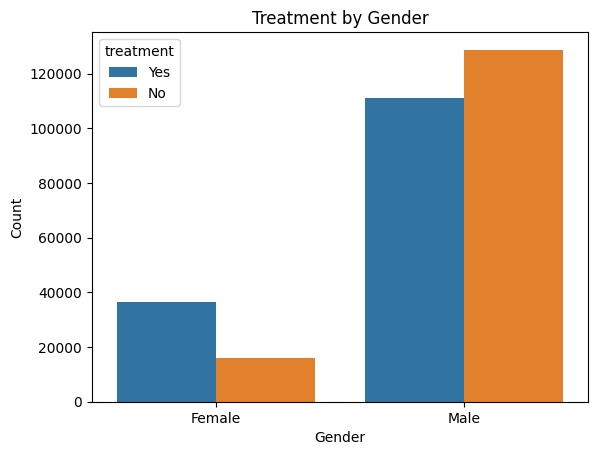

In [36]:
sns.countplot(x='Gender', hue='treatment', data=df)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Treatment by Gender")
plt.show()

The chart shows that females are more likely to seek mental health treatment compared to males, indicating a higher level of awareness or willingness to access care. In contrast, males represent a larger untreated group, which may point to stigma, underreporting, or limited access to mental health services. These gender-based differences are important for designing targeted interventions and setting fair, data-driven insurance premiums in mental health coverage.